In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

In [4]:
def convert_to_gray(img):
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        if (channel_count == 3) :
            return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    gray = convert_to_gray(img)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def mag_threshold(img, sobel_kernel=3,
                  thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = convert_to_gray(img)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = convert_to_gray(img)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
  

def write_image(name, img) :
    """
    Write an image with the correct color space.
    """
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        if (channel_count == 3) :
            cv2.imwrite(name, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        cv2.imwrite(name, img)
        

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the image to overlay on top of initial img.
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_lines_between_points(shape, points, color=[255, 0, 0], thickness=10):
    """
    Draw `lines` on `img` with `color` and `thickness`
    """
    img = np.zeros(shape, dtype=np.uint8)
    for idx in range(len(points) -1):
        cv2.line(img, tuple(points[idx]), tuple(points[idx + 1]), color, thickness)
    return img 


In [5]:

def calibrate_camera_from_image(img, nx , ny, objpoints, imgpoints):

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    shape = gray.shape[::-1]
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret :
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.figure()
        plt.imshow(img)
    return shape
    

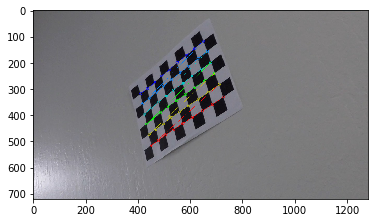

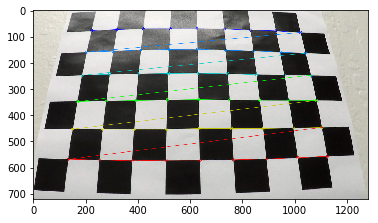

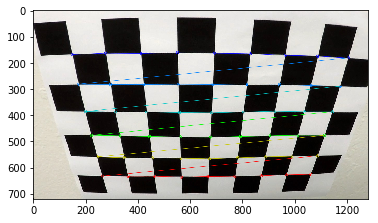

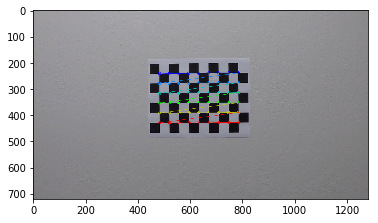

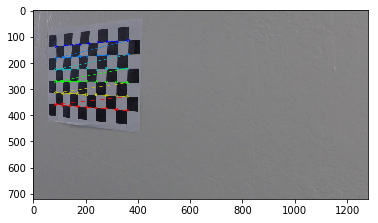

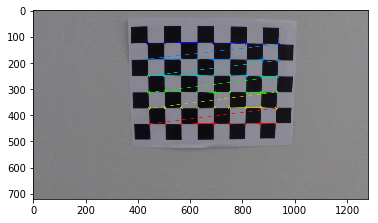

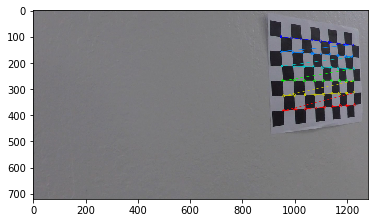

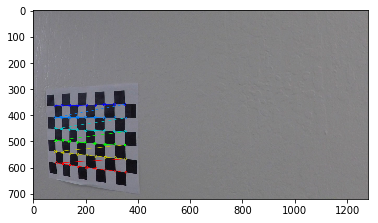

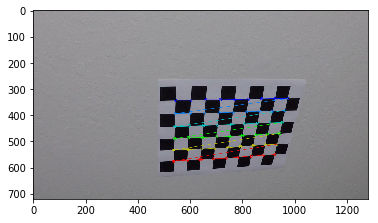

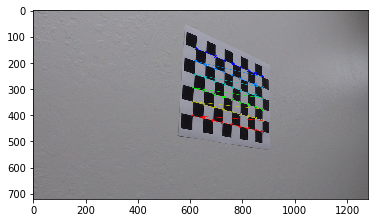

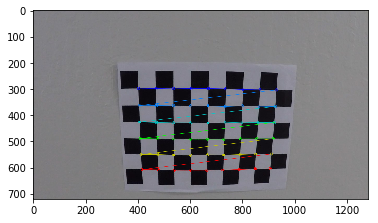

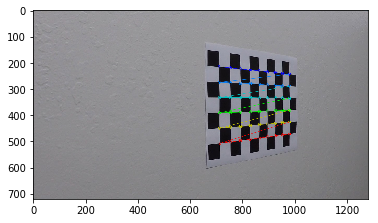

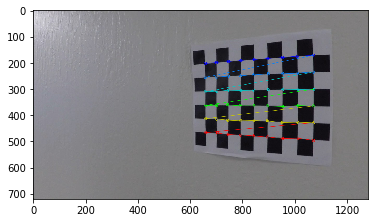

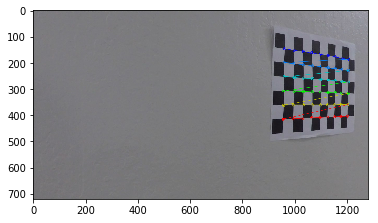

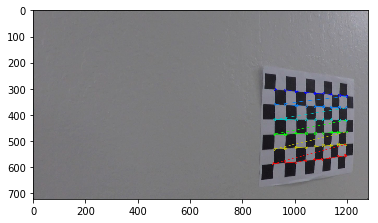

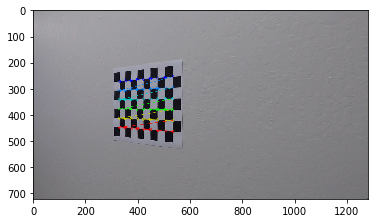

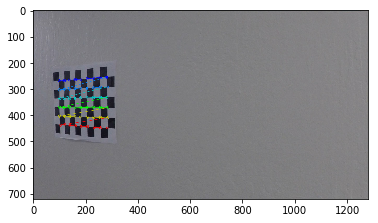

In [6]:
nx = 9 
ny = 6

objpoints = []
imgpoints = []
for file in glob.glob('camera_cal/*.jpg'):
    img = mpimg.imread(file)
    shape = calibrate_camera_from_image(img, nx , ny, objpoints, imgpoints)
 

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)


In [7]:
for file in glob.glob('test_images/*.jpg'):
    print(file)
    print(os.path.splitext(os.path.basename(file)))

test_images/straight_lines1.jpg
('straight_lines1', '.jpg')
test_images/test6.jpg
('test6', '.jpg')
test_images/straight_lines2.jpg
('straight_lines2', '.jpg')
test_images/test5.jpg
('test5', '.jpg')
test_images/test4.jpg
('test4', '.jpg')
test_images/test1.jpg
('test1', '.jpg')
test_images/test3.jpg
('test3', '.jpg')
test_images/test2.jpg
('test2', '.jpg')


output_images/straight_lines1_undistorted.jpg
output_images/test6_undistorted.jpg
output_images/straight_lines2_undistorted.jpg
output_images/test5_undistorted.jpg
output_images/test4_undistorted.jpg
output_images/test1_undistorted.jpg
output_images/test3_undistorted.jpg
output_images/test2_undistorted.jpg


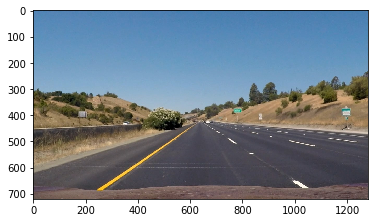

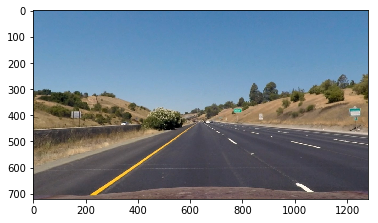

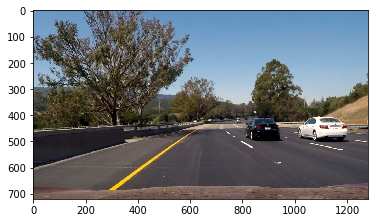

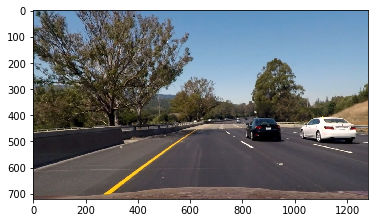

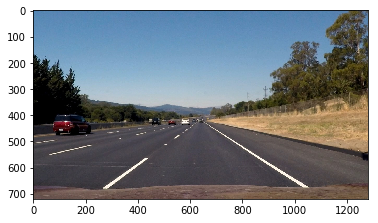

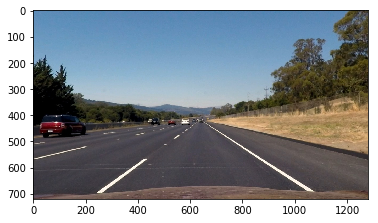

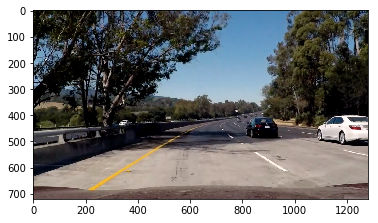

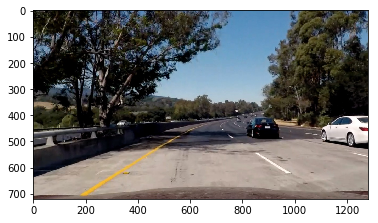

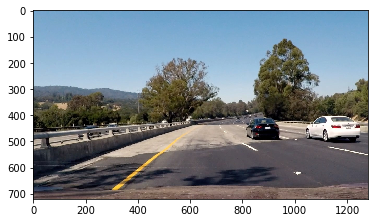

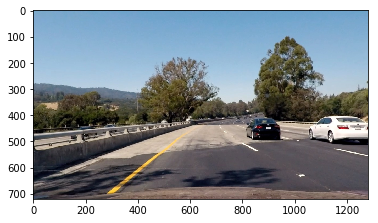

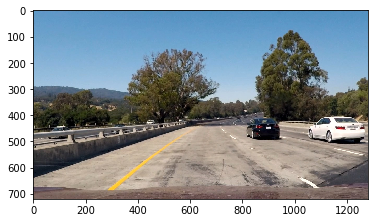

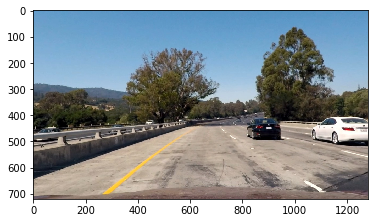

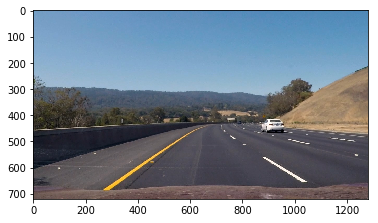

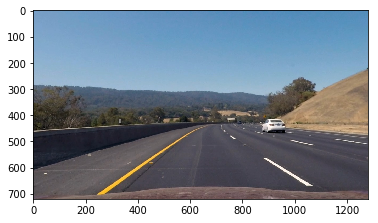

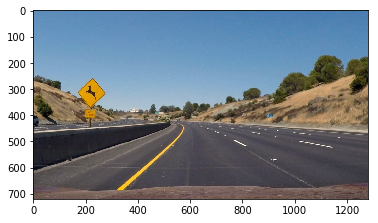

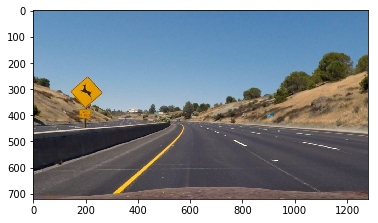

In [8]:
undistorted = []
for file in glob.glob('test_images/*.jpg'):
    name, ext = os.path.splitext(os.path.basename(file))
    target = os.path.join('output_images', name + '_undistorted.jpg')
    print(target)
    img = mpimg.imread(file)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    plt.figure()
    plt.imshow(img)    
    plt.figure()
    plt.imshow(undist)
    undistorted.append(undist)
    write_image(target, undist)


output_images/straight_lines1_undistorted.jpg
(1280, 720)
writing output_images/straight_lines1_undistorted_warped.jpg
output_images/test3_undistorted.jpg
(1280, 720)
writing output_images/test3_undistorted_warped.jpg
output_images/test6_undistorted.jpg
(1280, 720)
writing output_images/test6_undistorted_warped.jpg
output_images/test2_undistorted.jpg
(1280, 720)
writing output_images/test2_undistorted_warped.jpg
output_images/test5_undistorted.jpg
(1280, 720)
writing output_images/test5_undistorted_warped.jpg
output_images/test1_undistorted.jpg
(1280, 720)
writing output_images/test1_undistorted_warped.jpg
output_images/straight_lines2_undistorted.jpg
(1280, 720)
writing output_images/straight_lines2_undistorted_warped.jpg
output_images/test4_undistorted.jpg
(1280, 720)
writing output_images/test4_undistorted_warped.jpg


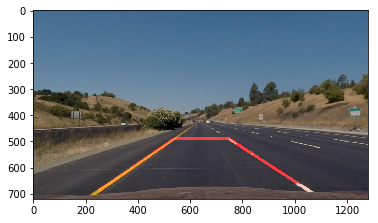

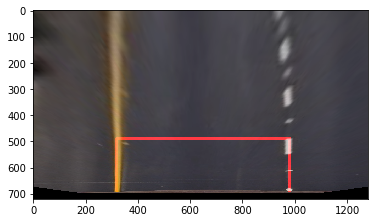

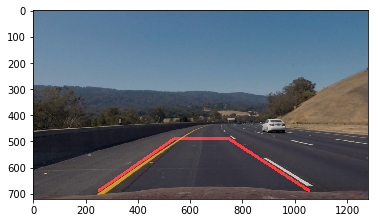

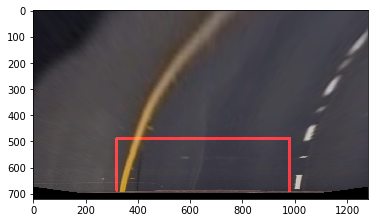

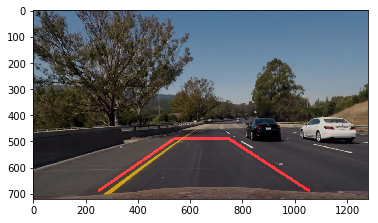

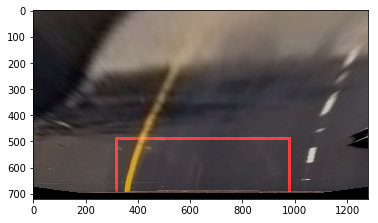

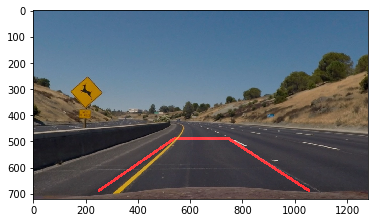

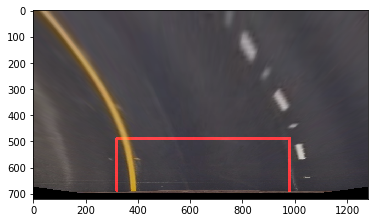

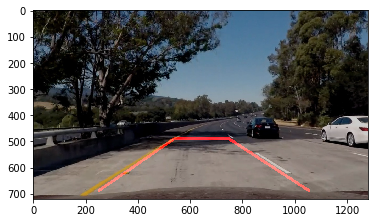

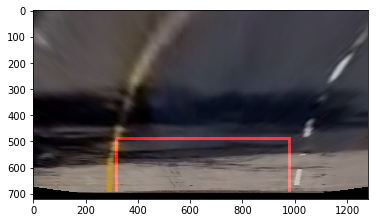

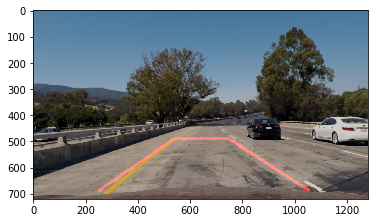

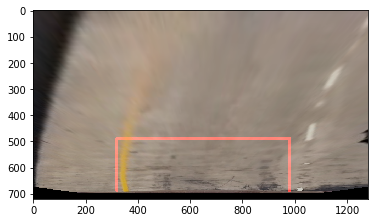

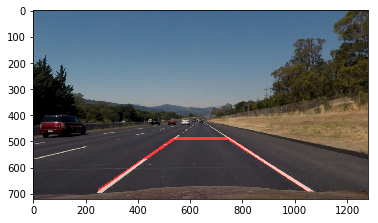

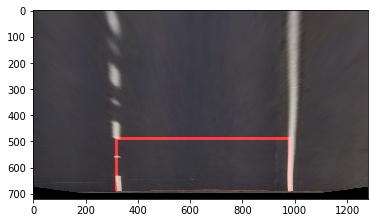

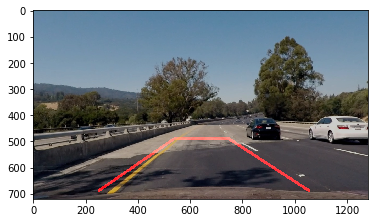

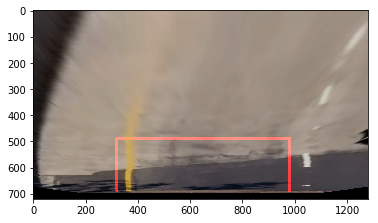

In [40]:
from scipy.ndimage.interpolation import zoom
import scipy.misc

# Create a perspective transform from the 2 straigtline images
for file in glob.glob('output_images/*undistorted.jpg'):
    print (file)
    name, ext = os.path.splitext(os.path.basename(file))
    target = os.path.join('output_images', name + '_warped.jpg')
    img = mpimg.imread(file)
#     img_size_pers = (img.shape[1], img.shape[0])
#     src = np.float32([[230.0, 700.0], [531.0,495.0], [762.5, 495.0], [1080.0, 700.0]])
#     dst = np.float32([[230.0, 1000.0], [230.0,795.0], [1080.0, 795.0], [1080.0, 1000.0]])
    
    
    img_size_pers = (img.shape[1], img.shape[0])
    src = np.float32([[251.0, 688.0], [540.0,489.0], [747.0, 489.0], [1055.0, 688.0]])
    
#     dst = np.float32([[350.0, 720.0], [350.0,300.0], [950.0, 300.0], [950.0, 720.0]])
    dst = np.float32([[320.0, 688.0], [320.0, 489.0],
                        [980.0, 489.0], [980.0, 688.0]])
    plt.figure()
    plt.imshow(weighted_img(draw_lines_between_points(np.shape(img), src), img))
    print(img_size_pers)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size_pers, flags=cv2.INTER_LINEAR)
    print("writing " + target)
    write_image(target, weighted_img(draw_lines_between_points(np.shape(warped), dst), warped))
    
#     warped = cv2.warpPerspective(img, M, img_size_pers, flags=cv2.INTER_LINEAR)
   
    plt.figure()
    plt.imshow(weighted_img(draw_lines_between_points(np.shape(warped), dst), warped))
    


In [ ]:
for file in glob.glob('output_images/*test*.jpg'):
    print (file)
    img = mpimg.imread(file)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    warped = warped[0:warped.shape[0]-41:,:]

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(warped)
    ax2.set_title('Perspective transformed', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def prepare_img(img, ksize=9, visualize=False):
    img_size = (img.shape[1], img.shape[0])
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    
    gradx_thresh = (46, 82)
    grady_thresh = (14, 166)
    mag_thresh = (17, 255)
    dir_thresh = (0.0, 0.47123889803846897)
    
    ksize = 9
    # Apply each of the thresholding functions
    gradx = abs_sobel_threshold(s_channel, orient='x', sobel_kernel=ksize, thresh=gradx_thresh)
    grady = abs_sobel_threshold(s_channel, orient='y', sobel_kernel=ksize, thresh=grady_thresh)
    mag_binary = mag_threshold(s_channel, sobel_kernel=ksize, thresh=mag_thresh)
    dir_binary = dir_threshold(s_channel, sobel_kernel=ksize, thresh=dir_thresh)

    combined = np.zeros_like(dir_binary, np.int8)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    if (visualize): 
        f, (ax1, ax2, ax3, ax4, ax5,ax6, ax7) = plt.subplots(1, 7, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(img)
        ax1.set_title(file + ' Original Image', fontsize=10)

        ax2.imshow(s_channel)
        ax2.set_title(file + ' s_channel Image - S', fontsize=10)

        ax3.imshow(gradx)
        ax3.set_title(file + ' gradx Image - S', fontsize=10)

        ax4.imshow(grady)
        ax4.set_title(file + ' grady Image - S', fontsize=10)

        ax5.imshow(mag_binary)
        ax5.set_title(file + ' mag_binary Image - S', fontsize=10)

        ax6.imshow(dir_binary)
        ax6.set_title(file + ' dir_binary Image - S', fontsize=10)

        ax7.imshow(combined, cmap='gray')
        ax7.set_title(file + ' Thresholded Grad. Dir.', fontsize=10)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return combined


def read_and_prepare_img(file, ksize=9, visualize=False):
    img = mpimg.imread(file)
    return prepare_img(img, ksize, visualize)

for file in glob.glob('output_images/*test*.jpg'):
    print (file)
    read_and_prepare_img(file, 9, True)


In [ ]:
def process_image(img, visualize=False):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary_warped=prepare_img(undist)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    binary_warped *= 255
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    if (len(rightx) == 0 or len(leftx)== 0): return img
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 600
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')

    
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    if (visualize):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(img)
        ax1.set_title(file + ' Original Image', fontsize=10)
        ax2.imshow(out_img)
        ax2.plot(left_fitx, ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='yellow')
        # ax2.xlim(0, 1280)
        # ax2.ylim(720, 0)
        ax2.set_title(file + ' s_channel Image - S', fontsize=10)


    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    print(np.shape(pts))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    if (visualize):
        ax3.imshow(result)
    return result


def process_image_save_on_exception(img):
    try:
        return process_image(img)
    except :
        print("Failed to process img")
        write_image("error_image.jpg", img)
        raise
    

for file in glob.glob('test_images/*test*.jpg'):
    print (file)
    img = mpimg.imread(file)
    process_image(img, visualize=True)


In [ ]:

img = mpimg.imread("error_image.jpg")
prepare_img(img, visualize=True)

process_image(img)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
def write_image(name, img) :
    """
    Write an image with the correct color space.
    """
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        if (channel_count == 3) :
            cv2.imwrite(name, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        cv2.imwrite(name, img)

global count

def process_image_save(img):
    global count
    if (count % 60) == 0:
        write_image("challenge_images/challleng_image_{}.jpg".format(count), img)
    count = count + 1
    return img

count = 0
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image_save) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
from lane_lines import LaneLines 


In [ ]:
lanes = LaneLines('cal_images')